In [1]:
import utils
import emission
import transition
import viterbi

In [2]:
entity_f_list = []
sentiment_f_list = []
vocab_size = []
new_vocab = []
k_list = []

In [3]:
LOWER = False
REP_NUM = True
REP_SYM = True

In [4]:
dataset_folder = "data/AL/"

In [5]:
def run_k(k):
    print(">> Test k =", k)
    train_data = dataset_folder + "train"
    lines = utils.read_file_to_lines(train_data)
    
    emission_data = emission.generate_emission_table(lines,
                                                 mode="al",
                                                 lower=LOWER,
                                                 replace_number=REP_NUM,
                                                 replace_symbol=REP_SYM)
    
    hashmap = emission_data["x_hashmap"]
    word_freq = emission_data["x_word_freq"]
    smoothed_hashmap = utils.add_unk(hashmap, word_freq, k=k)
    emission_data["x_hashmap"] = smoothed_hashmap

    x_vocab = utils.get_emission_vocab(smoothed_hashmap)
    vocab_size.append(len(x_vocab))
    
    transition_pairs = transition.generate_transition_pairs(lines)
    
    y_pairs = transition_pairs["Y_pairs"]
    y_vocab = transition_pairs["y_vocab"]
    y_freq = transition_pairs["y_freq"]
    
    transition_data = transition.generate_transition_data(y_pairs, y_vocab)
    
    hmm = viterbi.HMM()
    hmm.fit_word_tokenizer(x_vocab)
    hmm.fit_pos_tokenizer(y_vocab)
    hmm.build_transition_weights(y_freq, transition_data)
    hmm.build_emission_weights(emission_data)
    
    train_data = dataset_folder + "dev.in"
    lines = utils.read_file_to_lines(train_data)

    sentences = []

    while len(lines) > 1:
        sentence_break = lines.index("")
        sentence_xy = lines[:sentence_break]
        words = [utils.preprocess_text(token,
                                       mode="al",
                                       lower=LOWER,
                                       replace_number=REP_NUM,
                                       replace_symbol=REP_SYM)
                 for token in sentence_xy]
        sentence = " ".join(words).strip()
        sentences.append(sentence)
        lines = lines[sentence_break+1:]
        
    new_words = []
    for line in sentences:
        for word in line.split(" "):
            if word not in x_vocab:
                new_words.append(word)

    new_words = list(set(new_words))
    new_words.sort()
    new_vocab.append(len(new_words))
    
    # only for the progress bar!
    try:
        from tqdm import tqdm
        USE_TQDM = True
    except Exception as e:
        print(e, "TQDM import error, disable progress bar")

    if USE_TQDM:
        sentences_it = tqdm(sentences)
    else:
        sentences_it = sentences
        
    preds = []

    for line in sentences_it:
        pred = hmm.viterbi_predict(line)
        pred = hmm.pos_tokens_to_labels(pred)
        preds.append(pred)

    assert len(sentences) == len(preds)
    
    outfile = dataset_folder + "dev.p5.out"

    with open(outfile, "w") as f:
        for sentence, pred in zip(sentences, preds):
            word_array = sentence.split(" ")
            try:
                assert len(word_array) == len(pred)
                for i, word in enumerate(word_array):
                    f.write(word + " " + pred[i] +"\n")
            except:
                print(word_array)
                print(pred)
                break
            f.write("\n")
    
    gold_data = dataset_folder + "dev.out"
    pred_data = outfile

    data = utils.run_eval(gold_data, pred_data)
    
    entity_f_list.append(data["entity_f"])
    sentiment_f_list.append(data["sentiment_f"])
    k_list.append(k)

    print("Results")
    print("Entity F:", data["entity_f"])
    print("Sentiment F:", data["sentiment_f"])

In [6]:
for i in range(1, 10):
    run_k(i)

>> Test k = 1


100%|██████████| 1492/1492 [01:12<00:00, 20.48it/s]


Results
Entity F: 0.6527
Sentiment F: 0.5536
>> Test k = 2


100%|██████████| 1492/1492 [01:13<00:00, 20.29it/s]


Results
Entity F: 0.6539
Sentiment F: 0.5598
>> Test k = 3


100%|██████████| 1492/1492 [01:12<00:00, 20.47it/s]


Results
Entity F: 0.6557
Sentiment F: 0.5615
>> Test k = 4


100%|██████████| 1492/1492 [01:13<00:00, 20.41it/s]


Results
Entity F: 0.6569
Sentiment F: 0.5626
>> Test k = 5


100%|██████████| 1492/1492 [01:13<00:00, 20.42it/s]


Results
Entity F: 0.6574
Sentiment F: 0.564
>> Test k = 6


100%|██████████| 1492/1492 [01:12<00:00, 20.45it/s]


Results
Entity F: 0.6581
Sentiment F: 0.5649
>> Test k = 7


100%|██████████| 1492/1492 [01:14<00:00, 20.16it/s]


Results
Entity F: 0.6582
Sentiment F: 0.565
>> Test k = 8


100%|██████████| 1492/1492 [01:14<00:00, 20.15it/s]


Results
Entity F: 0.6568
Sentiment F: 0.5639
>> Test k = 9


100%|██████████| 1492/1492 [01:13<00:00, 20.17it/s]


Results
Entity F: 0.6567
Sentiment F: 0.5639


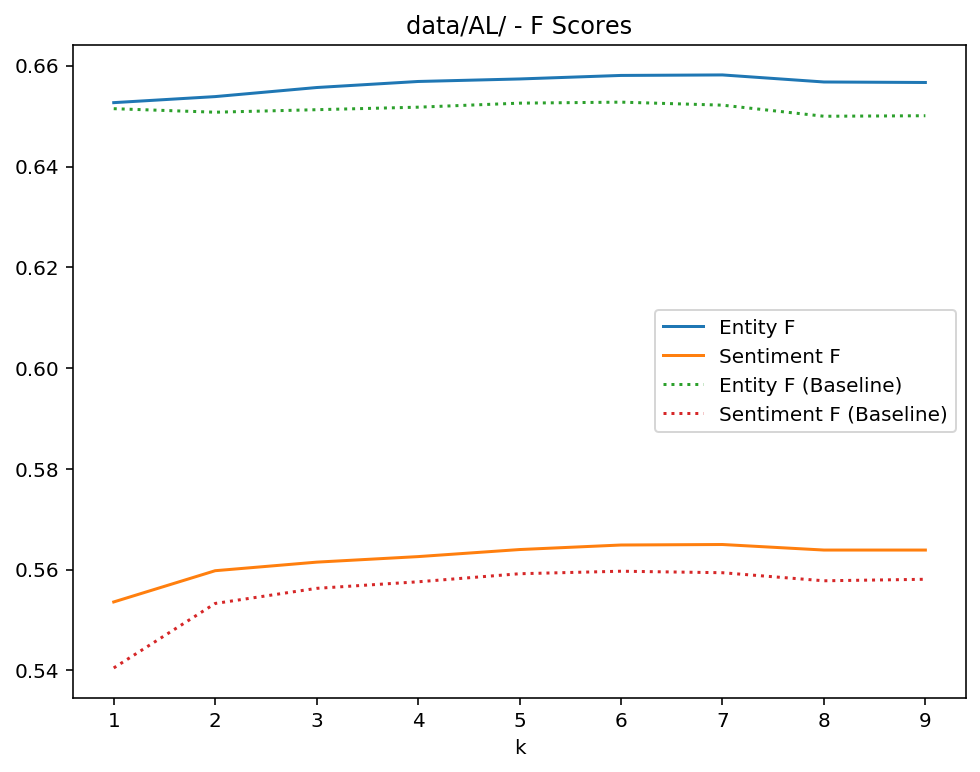

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

baseline_entity = [0.6515, 0.6508, 0.6513, 0.6518, 0.6526, 0.6528, 0.6522, 0.65, 0.6501]
baseline_sentiment = [0.5405, 0.5533, 0.5563, 0.5576, 0.5592, 0.5597, 0.5594, 0.5578, 0.5581]

plt.figure(figsize=(8,6))
plt.plot(k_list, entity_f_list, label="Entity F")
plt.plot(k_list, sentiment_f_list, label="Sentiment F")
plt.plot(k_list, baseline_entity, label="Entity F (Baseline)", linestyle="dotted")
plt.plot(k_list, baseline_sentiment, label="Sentiment F (Baseline)", linestyle="dotted")
plt.xlabel("k")
#plt.ylim(0.7, 0.9)
plt.title(dataset_folder + " - F Scores")
plt.legend()
plt.show()

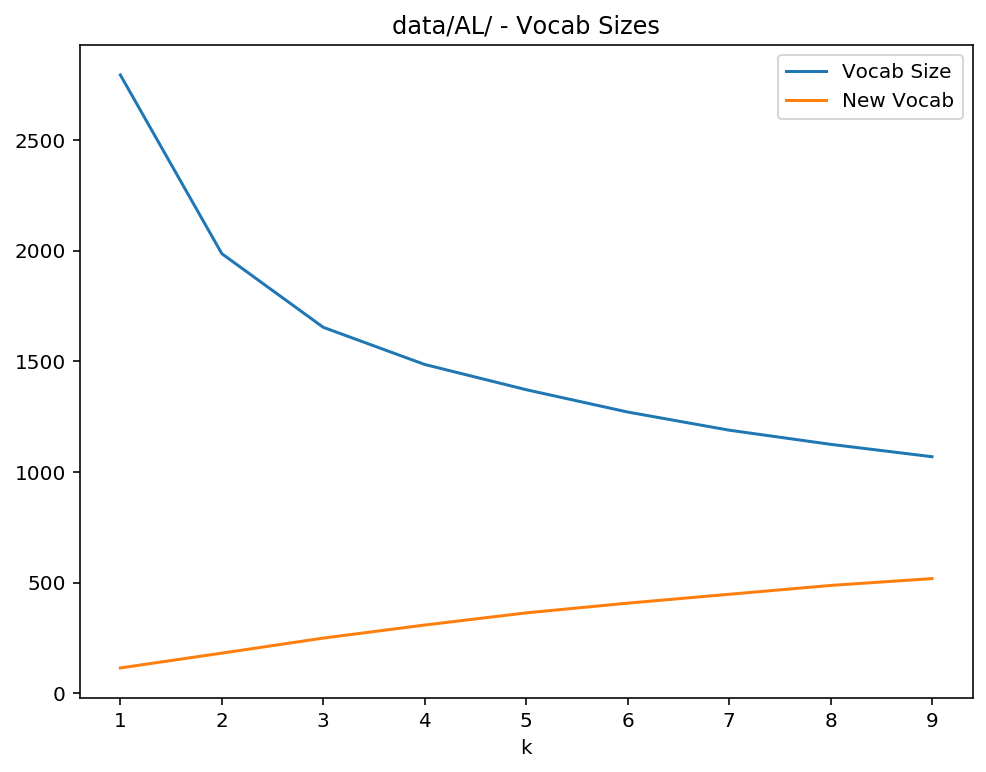

In [8]:
plt.figure(figsize=(8,6))
plt.plot(k_list, vocab_size, label="Vocab Size")
plt.plot(k_list, new_vocab, label="New Vocab")
plt.xlabel("k")
plt.title(dataset_folder + " - Vocab Sizes")
plt.legend()
plt.show()